## Tutorial 3: Running spatially distributed simulations

While the `Ensemble` class discussed in the previous tutorial can be used to run multiple locations via different file managers, this is generally not the way that a spatially-distributed SUMMA simulation would be run. For spatially-distributed run pysumma has a `Distributed` class, which makes running these types of simulations easier. For this example we will run a simulation of the Yakima River Basin in the Pacific Northwestern United States. As ususal, we start with some standard imports and get the model setup installed for local use.


In [1]:
import xarray as xr
import pysumma as ps
import geopandas as gpd
import cartopy.crs as ccrs
import pysumma.plotting as psp
import matplotlib.pyplot as plt
!cd data/yakima && ./install_local_setup.sh && cd -

/home/bzq/workspace/pysumma/tutorial


### Running a basic `Distributed` simulation

Before getting into any of the further customization that can be done with a `Distributed` object let's just run through the basic usage. If you are running this tutorial interactively, you are probably on a small binder instance or other machine that has a small amount of compute capacity. It's important to point out that in this tutorial we will only run small examples, the parallelism approach of the `Distributed` object can easily scale out to hundreds of cores. As with the `Simulation` and `Ensemble` objects, a `Distributed` object must be given a some information, namely the SUMMA executable and a file manager, to be instantiated. Additionally we will set 4 workers, which means that 4 SUMMA simulations will be run in parallel, and the `num_chunks` to 8. `num_chunks` describes how many simulations will be run in total. In this configuration each worker will run two SUMMA simulations. We can inspect these chunks directly by inspecting the underlying keys for the `Simulation`s in the `Distributed` instance, via `yakima.simulations.keys()`. Doing so we see that there are 8 simulations, each with 36 GRU (denoted by `gX-X+35`). As an alternative to the `num_chunks` argument, you can also use the `chunk_size` argument to specify how many GRU to run in each chunk.

In [2]:
summa_exe = 'summa.exe'
file_manager = './data/yakima/file_manager.txt'

yakima = ps.Distributed(summa_exe, file_manager, num_workers=4, num_chunks=8)
yakima.simulations.keys()

/home/bzq/miniconda3/envs/all/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43425 instead
  http_address["port"], self.http_server.port


dict_keys(['g1-36', 'g37-72', 'g73-108', 'g109-144', 'g145-180', 'g181-216', 'g217-252', 'g253-285'])

<br> 

As with the `Simulation` and `Ensemble` objects we can simply call `.run()` to start the simulations running. If you are running this tutorial interactively, this may take a moment because of the limited compute capacity of the binder instance. We have included the `%%time` magic to time how long this cell takes to run locally. You might expect this to take up to roughly two times the amount of time on the binder instance than is reported in the documentation at [pysumma.readthedocs.io](https://pysumma.readthedocs.io). As with the `Ensemble` we can use the `.summary()` method once the runs are complete to ensure that they all exit with status `Success`.

In [3]:
%%time
yakima.run()
print(yakima.summary())

{'Success': ['g1-36', 'g37-72', 'g73-108', 'g109-144', 'g145-180', 'g181-216', 'g217-252', 'g253-285'], 'Error': [], 'Other': []}
CPU times: user 10.6 s, sys: 1.93 s, total: 12.5 s
Wall time: 1min 4s


<br> 

Once you've gotten a successful set of simulations, it's time to look at the output! This can be done with the `merge_output()` method, which will collate all of the different runs together into a single `xr.Dataset`. If you want to open each of the output files individually without merging them you can sue the `open_output()` method. Once we've merged everything together, we see that there are 285 GRU (and similarly here, 285 HRU).

In [4]:
yakima_ds = yakima.merge_output()
yakima_ds

<xarray.Dataset>
Dimensions:                         (gru: 285, hru: 285, ifcToto: 14, midToto: 13, time: 721)
Coordinates:
  * hru                             (hru) int64 17006965 17006967 ... 17009664
  * time                            (time) datetime64[ns] 2010-06-01 ... 2010...
  * gru                             (gru) int64 906922 906924 ... 909581 909583
Dimensions without coordinates: ifcToto, midToto
Data variables:
    pptrate                         (time, hru) float64 7.562e-05 ... 1.418e-05
    airtemp                         (time, hru) float64 279.2 279.1 ... 278.0
    windspd_mean                    (time, hru) float64 0.8894 0.8894 ... 1.266
    SWRadAtm                        (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    LWRadAtm                        (time, hru) float64 287.4 287.1 ... 288.3
    scalarCanopyIce                 (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    scalarCanopyLiq                 (time, hru) float64 0.2849 ... 0.07626
    scalarCanopyWat_mean            (time, hru) float64 0.2849 ... 0.07626
    scalarCanairTemp                (time, hru) float64 275.7 275.6 ... 275.8
    scalarCanopyTemp                (time, hru) float64 275.6 275.5 ... 275.6
    scalarSnowAlbedo                (time, hru) float64 -9.999e+03 ... -9.999...
    scalarSnowDepth_mean            (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    scalarSWE                       (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    mLayerTemp_mean                 (time, midToto, hru) float64 281.0 ... -9...
    scalarSurfaceTemp               (time, hru) float64 281.0 281.0 ... 279.2
    mLayerDepth_mean                (time, midToto, hru) float64 0.025 ... -9...
    mLayerHeight_mean               (time, midToto, hru) float64 0.0125 ... -...
    iLayerHeight_mean               (time, ifcToto, hru) float64 -0.0 ... -9....
    scalarTotalSoilLiq              (time, hru) float64 1.169e+03 ... 1.273e+03
    scalarTotalSoilIce              (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    scalarCanairNetNrgFlux          (time, hru) float64 -5.337 -5.354 ... -8.861
    scalarCanopyNetNrgFlux          (time, hru) float64 -7.165 -7.193 ... -11.87
    scalarGroundNetNrgFlux          (time, hru) float64 -27.66 -27.68 ... -19.02
    scalarLWNetUbound               (time, hru) float64 -40.71 -40.77 ... -39.55
    scalarSenHeatTotal              (time, hru) float64 0.4441 0.4447 ... 3.267
    scalarLatHeatTotal              (time, hru) float64 -0.2061 ... -3.392
    scalarLatHeatCanopyEvap         (time, hru) float64 -0.1114 ... -2.079
    scalarLatHeatCanopyTrans        (time, hru) float64 -0.01746 ... -1.063
    scalarLatHeatGround             (time, hru) float64 -0.07726 ... -0.2504
    scalarCanopySublimation         (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    scalarSnowSublimation           (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    scalarCanopyTranspiration       (time, hru) float64 -6.98e-09 ... -4.248e-07
    scalarCanopyEvaporation         (time, hru) float64 -4.454e-08 ... -8.311...
    scalarGroundEvaporation         (time, hru) float64 -3.089e-08 ... -1.001...
    scalarThroughfallSnow           (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    scalarThroughfallRain           (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    scalarCanopySnowUnloading_mean  (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    scalarRainPlusMelt              (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    scalarInfiltration              (time, hru) float64 2.479e-14 ... 0.0
    scalarExfiltration              (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    scalarSurfaceRunoff             (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    scalarSoilBaseflow              (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    scalarAquiferBaseflow           (time, hru) float64 2.228e-11 ... 4.876e-09
    scalarTotalRunoff               (time, hru) float64 2.228e-11 ... 4.876e-09
    scalarNetRadiation              (time, hru) float64 -40.71 -40.77 ... -39.55
 

### Basic visualization

Once we have run a successful simulation you might note that the `gru` dimension doesn't contain any geometry data on which we can actually draw our output. To do that we will use the associated shapefile, loaded in via GeoPandas, and plot the mean surface temperature via the `psp.spatial` functionality. For more information on the `spatial` plotting capabilities see the [plotting page in the documentation](https://pysumma.readthedocs.io/en/latest/plotting.html). Here we plot the traces of the input precipitation rate and total soil moisture timeseries for each of the HRU as well as a spatial plot showing the mean soil moisture over the simulation period.

In [5]:
yakima_ds

<xarray.Dataset>
Dimensions:                         (gru: 285, hru: 285, ifcToto: 14, midToto: 13, time: 721)
Coordinates:
  * hru                             (hru) int64 17006965 17006967 ... 17009664
  * time                            (time) datetime64[ns] 2010-06-01 ... 2010...
  * gru                             (gru) int64 906922 906924 ... 909581 909583
Dimensions without coordinates: ifcToto, midToto
Data variables:
    pptrate                         (time, hru) float64 7.562e-05 ... 1.418e-05
    airtemp                         (time, hru) float64 279.2 279.1 ... 278.0
    windspd_mean                    (time, hru) float64 0.8894 0.8894 ... 1.266
    SWRadAtm                        (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    LWRadAtm                        (time, hru) float64 287.4 287.1 ... 288.3
    scalarCanopyIce                 (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    scalarCanopyLiq                 (time, hru) float64 0.2849 ... 0.07626
    scalarCanopyWat_mean            (time, hru) float64 0.2849 ... 0.07626
    scalarCanairTemp                (time, hru) float64 275.7 275.6 ... 275.8
    scalarCanopyTemp                (time, hru) float64 275.6 275.5 ... 275.6
    scalarSnowAlbedo                (time, hru) float64 -9.999e+03 ... -9.999...
    scalarSnowDepth_mean            (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    scalarSWE                       (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    mLayerTemp_mean                 (time, midToto, hru) float64 281.0 ... -9...
    scalarSurfaceTemp               (time, hru) float64 281.0 281.0 ... 279.2
    mLayerDepth_mean                (time, midToto, hru) float64 0.025 ... -9...
    mLayerHeight_mean               (time, midToto, hru) float64 0.0125 ... -...
    iLayerHeight_mean               (time, ifcToto, hru) float64 -0.0 ... -9....
    scalarTotalSoilLiq              (time, hru) float64 1.169e+03 ... 1.273e+03
    scalarTotalSoilIce              (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    scalarCanairNetNrgFlux          (time, hru) float64 -5.337 -5.354 ... -8.861
    scalarCanopyNetNrgFlux          (time, hru) float64 -7.165 -7.193 ... -11.87
    scalarGroundNetNrgFlux          (time, hru) float64 -27.66 -27.68 ... -19.02
    scalarLWNetUbound               (time, hru) float64 -40.71 -40.77 ... -39.55
    scalarSenHeatTotal              (time, hru) float64 0.4441 0.4447 ... 3.267
    scalarLatHeatTotal              (time, hru) float64 -0.2061 ... -3.392
    scalarLatHeatCanopyEvap         (time, hru) float64 -0.1114 ... -2.079
    scalarLatHeatCanopyTrans        (time, hru) float64 -0.01746 ... -1.063
    scalarLatHeatGround             (time, hru) float64 -0.07726 ... -0.2504
    scalarCanopySublimation         (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    scalarSnowSublimation           (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    scalarCanopyTranspiration       (time, hru) float64 -6.98e-09 ... -4.248e-07
    scalarCanopyEvaporation         (time, hru) float64 -4.454e-08 ... -8.311...
    scalarGroundEvaporation         (time, hru) float64 -3.089e-08 ... -1.001...
    scalarThroughfallSnow           (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    scalarThroughfallRain           (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    scalarCanopySnowUnloading_mean  (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    scalarRainPlusMelt              (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    scalarInfiltration              (time, hru) float64 2.479e-14 ... 0.0
    scalarExfiltration              (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    scalarSurfaceRunoff             (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    scalarSoilBaseflow              (time, hru) float64 0.0 0.0 0.0 ... 0.0 0.0
    scalarAquiferBaseflow           (time, hru) float64 2.228e-11 ... 4.876e-09
    scalarTotalRunoff               (time, hru) float64 2.228e-11 ... 4.876e-09
    scalarNetRadiation              (time, hru) float64 -40.71 -40.77 ... -39.55
 

<GeoAxesSubplot:>

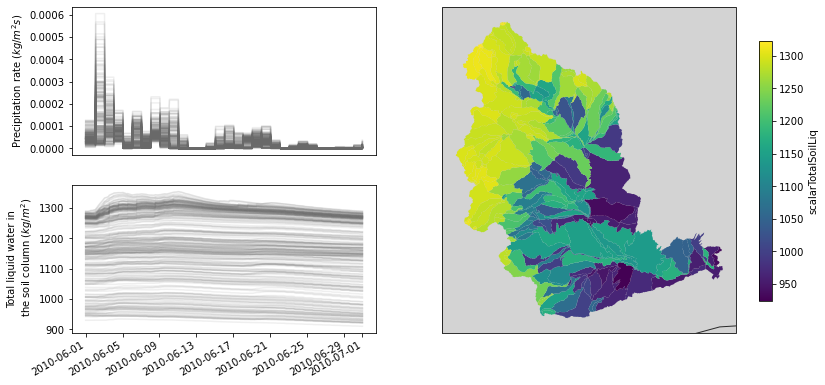

In [6]:
shapefile = './data/yakima/shapefile/yakima.shp'
gdf = gpd.GeoDataFrame.from_file(shapefile)

fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, 0], )
yakima_ds['pptrate'].plot.line(x='time', ax=ax1, add_legend=False, color='dimgrey', alpha=0.1)
ax1.set_xlabel('')
ax1.set_xticks([])
ax1.set_ylabel('Precipitation rate ($kg / m^2 s$)')

ax2 = fig.add_subplot(gs[1, 0], )
yakima_ds['scalarTotalSoilLiq'].plot.line(x='time', ax=ax2, add_legend=False, color='dimgrey', alpha=0.1)
ax2.set_ylabel('Total liquid water in\n the soil column ($kg/m^2$)')
ax2.set_xlabel('')

ax3 = fig.add_subplot(gs[:, 1], projection=ccrs.Mercator())
psp.spatial(yakima_ds['scalarTotalSoilLiq'].mean(dim='time'), gdf, ax=ax3)

### Further configuration, and more advanced parallelism

The Yakima River Basin given as an example here is a relatively small simulation of about 300 HRU for a month, but the parallelism approach built into the `Distributed` object can generally scale to many cores. Under the hood we rely on the [`dask` library](https://dask.org/) to manage the scheduling of the parallel runs of both the `Ensemble` and `Distributed` objects. While we won't actually run any simulations with these configurations, we show the code as a reference.

In [7]:
from dask.distributed import Client
from dask.distributed import LocalCluster
from dask_jobqueue import SLURMCluster

For local runs (e.g. your laptop or a big workstation machine), you can use the `LocalCluster`. For use on HPC machines, you will probably need to submit your jobs to the scheduler. This can be done via [`dask_jobqueue`](https://jobqueue.dask.org/en/latest/). Here we show how to use the `SLURMCluster`, but [other schedulers are supported](https://jobqueue.dask.org/en/latest/api.html).


In [ ]:
# Local example
N_WORKERS = 16 # A big machine might have 16 processors
local_cluster = LocalCluster(n_workers=N_WORKERS, threads_per_worker=1) # Each SUMMA simulation runs as a single-threaded process by default
local_example = Client(local_cluster) # This connects the compute cluster to the process running in this notebook

yakima_local = ps.Distributed(summa_exe, file_manager, client=local_example)

# If you have the resources, you can just call `yakima_local.run()` just as before

In [ ]:
# SLURM example
N_WORKERS = 285 # On HPC maybe we want to run each GRU independently
slurm_cluster = SLURMCluster(cores=N_WORKERS, memory='4GB',      # Set the number of cores and memory per worker
                             queue='default', project='Pxyzxyz') # Set your queue and project code

slurm_example = Client(slurm_cluster) # This connects the compute cluster to the process running in this notebook
yakima_slurm = ps.Distributed(summa_exe, file_manager, client=slurm_example)

# If you have the resources, you can just call `yakima_slurm.run()` just as before